## Example spectra

Here, we show generating an example synthetic spectra, calculating the scores, etc.

In [2]:
# Standard library imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Project specific imports
import QSOtools as QT

In [4]:
# Set some preferences for plt...

In [5]:
workdir = './'

What kind of spectra are available in SDSS?

In [6]:
SDSScat = pd.read_csv(workdir+'datfiles/AllQSOspec_zgt2p1.csv')
SDSScat.head()

,specObjID,ra,dec,z,plate,mjd,fiberid,urlfits
0,300710684738480128,147.17010,0.539087,2.243463,267,51608,347,http://dr13.sdss.org/sas/dr13/sdss/spectro/red...
1,302891571118893056,150.98397,-0.994577,2.110910,269,51910,89,http://dr13.sdss.org/sas/dr13/sdss/spectro/red...
2,302973209857255424,150.69524,0.351117,2.167938,269,51910,386,http://dr13.sdss.org/sas/dr13/sdss/spectro/red...
3,305160412909824000,154.62245,-0.141852,2.137572,271,51883,151,http://dr13.sdss.org/sas/dr13/sdss/spectro/red...
4,305284657723762688,155.53053,0.800136,2.107791,271,51883,603,http://dr13.sdss.org/sas/dr13/sdss/spectro/red...


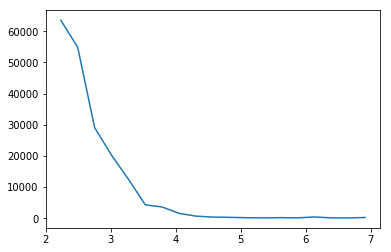

In [7]:
zbins = np.linspace(SDSScat['z'].min(),SDSScat['z'].max(),20)
zmids = 0.5*(zbins[:-1]+zbins[1:])

hist,_ = np.histogram(SDSScat['z'],zbins)
plt.plot(zmids,hist)
plt.show()

Define some things for our example spectra.

In [52]:
Lya = QT.Lya # This is already defined in QSOtools.
z_em = 3.0
DLA_definition = 20.3 # What is the column density of a DLA?
v_min = -25000.0
v_max = 300.0

In [53]:
# We want a spectra with at lease one QSO!
QSO_present = 0
attempts = 0

while QSO_present == 0:
    attempts = attempts+1
    spec_tuple = QT.generate_spectrum(z_em,v_min=v_min,v_max=v_max)
    observed_wv,observed_fl,observed_sig,absorber_CDs,absorber_zs = spec_tuple
    
    if any(absorber_CDs > DLA_definition):
        QSO_present = 1 # So we can quit the loop if we've found a DLA!
print('Generated a DLA after %i attempts' %attempts)

Generated a DLA after 17 attempts


In [59]:
print('The absorbers with large column densities are (descending):')
with np.printoptions(precision=3, suppress=True):
    print(absorber_CDs)

The absorbers with large column densities are (descending):
[20.368 20.116]


We're really only intrested in the bits blueward of the Ly$\alpha$ emission.

In [60]:
prox_wv_max = (1.0 + z_em)*(1.0 + v_max/QT.c)*QT.Lya
prox_wv_min = (1.0 + z_em)*(1.0 + v_min/QT.c)*QT.Lya
prox_mask = (prox_wv_min < observed_wv) & (observed_wv < prox_wv_max)

wv  = observed_wv[prox_mask]
fl  = observed_fl[prox_mask]
sig = observed_sig[prox_mask]


We want to estimate the continuum.

In [61]:
cont = QT.get_continuum(z_em,wv,fl,sig,kind='smooth')

c_fl = fl/cont
c_sig = sig/cont


In [62]:
# We can access the true continnum -- the restframe QSO template:
true_cont_wv = QT.high_resolution_wv*(1.0+z_em)
true_cont_fl = QT.high_resolution_fl

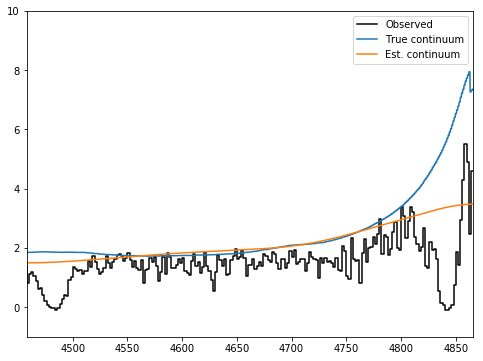

In [63]:
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(wv,fl,'k',drawstyle='steps',label='Observed')
ax.plot(true_cont_wv,true_cont_fl,label='True continuum')
ax.plot(wv,cont,label='Est. continuum')
ax.legend()

ax.set_xlim(wv.min(),wv.max())
ax.set_ylim(-1,10)

plt.show()

Now we have the continuum, we can estimate the scores.

How many pixels do we want to calculate the score over? A DLA has width of 3.5$\unicode{x212B}$ in restframe. So, at z=3.0, DLA will have width $3.5\times(1.0+z_{em})=14.0\unicode{x212B}$. SDSS has resolution 2.0$\unicode{x212B}$, so this is $7$ pixels.

In [64]:
Npix = int(QT.restframe_window*(1.0+z_em)/QT.SDSS_resolution)

In [65]:
score_wv,score_vals = QT.evaluate_scores(wv,c_fl,c_sig,Npix)

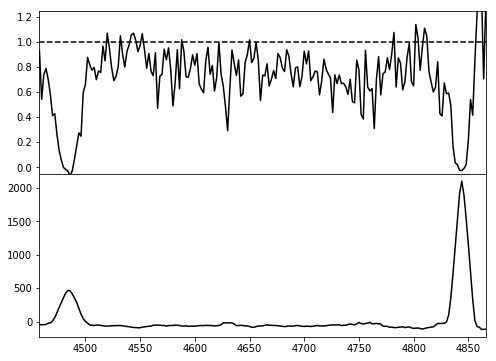

In [66]:
# Set up the axes...
gs = plt.GridSpec(2,1)
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(gs[:1,:])
ax2 = fig.add_subplot(gs[1:,:])

ax1.set_xlim(wv.min(),wv.max())
ax1.set_xticks([])

ax2.set_xlim(wv.min(),wv.max())
ax1.set_ylim(-0.05,1.25)

fig.subplots_adjust(hspace=0)

ax1.plot(wv,c_fl,'k')
ax1.plot(wv,c_fl/c_fl,'k--')
ax2.plot(score_wv,score_vals,'k')
plt.show()

Now we look for features in the scores...

In [67]:
feature_widths, feature_zs = QT.extract_features(z_em,score_wv,score_vals,threshold=20)

Match the features to the true absorbers -- currently by matching the largest absorber to the widest feature. Would also be nice to incude the absorber redshift comparison, but unsure of the best way to do this?

In [68]:
this_QSO = QT.match_features(z_em,absorber_CDs,absorber_zs,feature_widths,feature_zs)

In [71]:
cols = 'z_em absorber_CDs absorber_zs feature_widths feature_zs'.split()
matches = pd.DataFrame(this_QSO,columns=cols)
matches.head(n=20)

,z_em,absorber_CDs,absorber_zs,feature_widths,feature_zs
0,3.0,20.367561,2.687804,3.5,2.689323
1,3.0,20.116304,2.983985,3.0,2.983811
